In [1]:
# Basic
import numpy as np
from matplotlib import pyplot as plt

# For Dataset
from collections import deque, namedtuple
import random

# For solvers
from qpsolvers import solve_qp
from scipy.integrate import solve_ivp
from casadi import *

# For estimators
from torch import nn
import torch
import torch.nn.functional as F


## AAC system

In [2]:
class AAC:
    def __init__(self, m, c_d, f0, f1, f2, v_ego):
        self.m = m
        self.c_d = c_d
        self.f0 = f0
        self.f1 = f1
        self.f2 = f2
        self.v_ego = v_ego
        self.u = 0
        
        
    def update(self, x0, u, t, dt):
        
        x = MX.sym('x',3) # Three states
        
        p = x[0]
        v = x[1]
        z = x[2]
        
        
        Fr = self.f0 * v**2 + self.f1 * v + self.f2
        
        f = vertcat(
            v,
            -1/self.m*Fr,
            self.v_ego - v           
        )
        g = vertcat([
            0,
            1/self.m *u,
            0
        ])
        

        dx = f + g
        
        ode = {}         # ODE declaration
        ode['x']   = x   # states
        ode['ode'] = dx # right-hand side 

        # Construct a Function that integrates over 4s
        F = integrator('F','cvodes',ode,{'t0':t,'tf':t+dt})

        res = F(x0=x0)
        
        x_n = res['xf'].elements()
        
        return x_n 
        
        

## Controller

In [12]:
class LQPCBFCLF:
    def __init__(self, m_nom, ca_nom, cd_nom, f0_nom, f1_nom, f2_nom, v_ego_nom, v_des, Th, clf_rate, cbf_rate, p_slack):
        self.m = m_nom
        self.ca = ca_nom
        self.cd = cd_nom
        self.f0 = f0_nom
        self.f1 = f1_nom
        self.f2 = f2_nom
        self.v_ego = v_ego_nom 
        self.v_des = v_des
        self.Th = Th
        
        self.p_slack = p_slack
        self.cbf_rate = cbf_rate
        self.clf_rate = clf_rate
        
        
    def clf(self, symb_x):
        v = symb_x[1]        

        clf = (v - self.v_des)**2;
        return clf
        
    def cbf(self, symb_x):
        v = symb_x[1]
        z = symb_x[2]

        cbf = z - self.Th * v - 0.5  * (self.v_ego - v)**2 / (self.cd * 9.81);
        return cbf
        

    def dcbf(self, x, u):
        v = x[1]
        z = x[2]
        
        Fr = self.f0 * v**2 + self.f1 * v + self.f2

        dB = 1/self.m * (self.Th + (v - self.v_ego)/self.cd/9.81 ) * (Fr - u) + (self.v_ego - v)
        
        return dB
        
    def compute_controller(self, x, u_ref, A_h, B_h, weights):
        v = x[1]
        z = x[2]

        u = SX.sym('u')
        slack = SX.sym('slack')
        
        Fr = self.f0 * v**2 + self.f1 * v + self.f2
        
        V = self.clf(x)
        dV = (v - self.v_des)*(2/self.m*(u - u_ref))

        B = self.cbf(x);
        dB = 1/self.m * (self.Th + (v - self.v_ego)/self.cd/9.81 ) * (Fr - u) + (self.v_ego - v)
        
        print(dB)
        
        a_h = A_h.forward(x)
        b_h = B_h.forward(x)
        
        S = dB + a_h + b_h * u
        
        weight_input = 2/self.m**2
        
        fqp = (u_ref - u)**2 * weight_input + self.p_slack * slack**2
        gqp = vertcat( -dV - self.clf_rate*V + slack, S + self.cbf_rate * B)
        
        # Optimization
        qp = {'x': vertcat(u,slack), 'f':fqp, 'g':gqp}
        
        print(dB)
        
        S = nlpsol('S', 'ipopt', qp,{'verbose':False,'print_time':False})
        
        print(dB)
             

        r = S(lbg=0, lbx = -m*self.cd*g, ubx = m*self.ca*g)
        
        print(dB)
        
        k = r['x'].elements()[0]
        slack_sol = r['x'].elements()[1]
        #dasdasd
        
        return a_h, b_h, k, slack_sol, V, B, dB

## Dataset

In [4]:


Transition = namedtuple('Transition',
                        ('x', 'k', 'dh', 'dh_hat'))


class Dataset:
    def __init__(self):
        #self.capacity = capacity 
        self.D = deque()
        
    def reset(self):
        self.D = deque()
    
    def update(self, *args):
        self.D.append(Transition(*args))
        
    def get_D(self):
        sample = Transition(*zip(*self.D))
        return sample
        
    

## Estimator

In [5]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        m.weight.data.fill_(0.0)
        m.bias.data.fill_(0.0)

class Estimator:
    def __init__(self, input_size, output_size = 1):
        f1 = 50
        f2 = 50
        
        self.model = nn.Sequential(
                                  nn.Linear(input_size, f1),                   nn.Sigmoid(),
                                  nn.Linear(f1, f2),                           nn.Sigmoid(),
                                  nn.Linear(f2, output_size)
                                )
        
        self.model.apply(weights_init)
        
    def forward(self, x, train = False):
        x = torch.from_numpy(np.array(x)).float()
        #print(x)
        z = self.model(x)
        
        if not train:
            z = z.detach().float().item()
            
        return z

## Utils

In [6]:
def sample_initial_state(p_min = 0, p_max = 2,
                         v_min = 18, v_max = 22,
                         z_min = 38, z_max = 42):
    p0 = np.random.uniform(p_min, p_max)
    v0 = np.random.uniform(v_min, v_max)
    z0 = np.random.uniform(z_min, z_max)
    return [p0, v0, z0] # [0,20,40]##

class Derivator:
    def __init__(self, dt):
        self.x = 0
        self.dt = dt
        
    def update(self, x_n):
        dx = (x_n - self.x)/dt
        
        self.x = x_n
        
        
        return dx
    

# Parameters

In [7]:
dt = 0.02
simTime = 10

# Real parameters
v_ego = 22
v_des = 24
m  = 1650.0
g = 9.81

# 
f0 = 0.1
f1 = 5
f2 = 0.25
#

c_a = 0.3
c_d = 0.3
Th = 1.8

# Nominal parameters
f0_nom = 10*f0
f1_nom = 10*f1
f2_nom = 10*f2

p_slack = 2e-2
clf_rate = 5
cbf_rate = 5.

# Initial state
p0 = 0
v0 = 20
z0 = 40

x = [p0, v0 ,z0]

x_lst = []
u_lst = []
V_lst = []
B_lst = []
slack_lst = []


## Main

In [13]:
d = Dataset()
T = 10   # Number of experiences

aac = AAC(m, c_d, f0, f1, f2, v_ego)

cont = LQPCBFCLF(0.8*m, c_a, c_d, f0_nom, f1_nom, f2_nom, v_ego, v_des, Th, clf_rate, cbf_rate, p_slack)

A_h = Estimator(3)
A_h_opt = torch.optim.Adam(A_h.model.parameters(), lr = 1e-4)

B_h = Estimator(3)
B_h_opt = torch.optim.Adam(B_h.model.parameters(), lr = 1e-4)


weights = 0.2

x_lst = []
u_lst = []
V_lst = []
B_lst = []
B_perf_lst = []
slack_lst = []


a_h_lst = []
b_h_lst = []


for _ in range(T):
    x0 = sample_initial_state()
    x = x0
    derivator = Derivator(dt)
    
    xs = []
    us = []
    Vs = []
    Bs = []
    B_perfs = []
    slacks = []
    b_hs = []
    a_hs = []
    
    for t in np.arange(0, simTime, dt): #simTime
        # Get Fr
        v = x[1]
        Fr = f0_nom * v**2 + f1_nom * v + f2_nom

        # Control Input
        a_h, b_h, k, slack_sol, V, B, db_hat = cont.compute_controller(x, Fr, A_h, B_h, weights)
        
        B_perf = x[2] - Th * x[1] - 0.5  * (v_ego - x[1])**2 / (c_d * 9.81)

        # One step propagation in the system
        x_n = aac.update(x, k, t, dt)
        
        db = derivator.update(B)
        
        d.update(x, k, db, db_hat)
        
        xs.append(x)
        us.append(k)
        Vs.append(V)
        Bs.append(B)
        slacks.append(slack_sol)
        a_hs.append(a_h)
        b_hs.append(b_h)
        B_perfs.append(B_perf)
        
        x = x_n
        
        
    # Save data
    x_lst.append(xs)
    u_lst.append(us)
    V_lst.append(Vs)
    B_lst.append(Bs)
    slack_lst.append(slacks)
    a_h_lst.append(a_hs)
    b_h_lst.append(b_hs)
    B_perf_lst.append(B_perfs)

    # Train estimator
    sample = d.get_D()
        
    for x_i, k_i, dh_i, dh_hat_i in zip(sample.x, sample.k, sample.dh, sample.dh_hat ):
        S_i = A_h.forward(x_i, train = True) + B_h.forward(x_i, train = True)*k_i + cont.dcbf(x_i, k_i) #dh_hat_i 
        dasdasd
        Loss = F.mse_loss(torch.tensor(dh_i),S_i)

        A_h.model.zero_grad()
        B_h.model.zero_grad()

        Loss.backward()
        A_h_opt.step()
        B_h_opt.step()
    
        
        



((0.00110152*(1491.82-u))+1.01827)
((0.00110152*(1491.82-u))+1.01827)
((0.00110152*(1491.82-u))+1.01827)
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        3
Number of nonzeros in Lagrangian Hessian.............:        2

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        2
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        2
        inequality constraints with only lower bounds:        2
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper 

((0.0012064*(1529.46-u))+0.610816)
((0.0012064*(1529.46-u))+0.610816)
((0.0012064*(1529.46-u))+0.610816)
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        3
Number of nonzeros in Lagrangian Hessian.............:        2

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        2
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        2
        inequality constraints with only lower bounds:        2
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper 


Number of Iterations....: 8

                                   (scaled)                 (unscaled)
Objective...............:   2.1556553241064570e+01    2.1556553241064570e+01
Dual infeasibility......:   2.5757174171303632e-14    2.5757174171303632e-14
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5061438276967177e-09    2.5061438276967177e-09
Overall NLP error.......:   2.5061438276967177e-09    2.5061438276967177e-09


Number of objective function evaluations             = 14
Number of objective gradient evaluations             = 9
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 14
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 9
Number of Lagrangian Hessian evaluations             = 8
Total CPU secs in IPOPT (w/o function evaluations)   =      0.003
Total CPU secs in NLP function evaluations   

   0  2.7811643e+00 3.24e+01 5.00e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  2.3704024e+01 0.00e+00 1.34e-02  -1.0 3.24e+01    -  9.83e-01 1.00e+00h  1
   2  2.0062172e+01 0.00e+00 6.56e-02  -1.0 7.77e+02    -  8.55e-01 6.32e-01f  1
   3  2.0157980e+01 0.00e+00 4.42e+00  -1.0 1.16e+02    -  9.68e-01 1.25e-01f  4
   4  2.0119749e+01 0.00e+00 1.00e-06  -1.0 4.40e+00    -  1.00e+00 1.00e+00f  1
   5  1.9925908e+01 0.00e+00 2.83e-08  -2.5 1.45e+01    -  1.00e+00 1.00e+00f  1
   6  1.9919457e+01 0.00e+00 1.50e-09  -3.8 5.03e-01    -  1.00e+00 1.00e+00f  1
   7  1.9919159e+01 0.00e+00 1.84e-11  -5.7 2.23e-02    -  1.00e+00 1.00e+00f  1
   8  1.9919155e+01 0.00e+00 2.51e-14  -8.6 2.76e-04    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 8

                                   (scaled)                 (unscaled)
Objective...............:   1.9919155450174056e+01    1.9919155450174056e+01
Dual infeasibility......:   2.5091040356528538e-14    2.5091040356528538e-14
Constraint viola

Overall NLP error.......:   2.5061631225849442e-09    2.5061631225849442e-09


Number of objective function evaluations             = 11
Number of objective gradient evaluations             = 9
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 11
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 9
Number of Lagrangian Hessian evaluations             = 8
Total CPU secs in IPOPT (w/o function evaluations)   =      0.003
Total CPU secs in NLP function evaluations           =      0.000

EXIT: Optimal Solution Found.
((0.00130314*(1564.47-u))+0.234997)
((0.00130393*(1564.75-u))+0.231956)
((0.00130393*(1564.75-u))+0.231956)
((0.00130393*(1564.75-u))+0.231956)
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number

((0.00131807*(1569.89-u))+0.177022)
((0.00131807*(1569.89-u))+0.177022)
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        3
Number of nonzeros in Lagrangian Hessian.............:        2

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        2
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        2
        inequality constraints with only lower bounds:        2
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objecti

Number of nonzeros in inequality constraint Jacobian.:        3
Number of nonzeros in Lagrangian Hessian.............:        2

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        2
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        2
        inequality constraints with only lower bounds:        2
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.8440506e+00 2.78e+01 5.00e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  1.8312776e+01 0.00e+00 1.08e-02  -1.0 2.79e+01    -  9.84e-01 1.00e+00h  1
   2  1.6443153e+01 0.00e+00 3.13e-01  -1.0 6.36e+0

((0.00133905*(1577.53-u))+0.0955112)
((0.00133905*(1577.53-u))+0.0955112)
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        3
Number of nonzeros in Lagrangian Hessian.............:        2

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        2
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        2
        inequality constraints with only lower bounds:        2
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objec

   3  1.5583617e+01 0.00e+00 1.99e+00  -1.0 5.04e+01    -  9.85e-01 5.00e-01f  2
   4  1.5508424e+01 0.00e+00 1.00e-06  -1.0 1.15e+01    -  1.00e+00 1.00e+00f  1
   5  1.5315267e+01 0.00e+00 2.83e-08  -2.5 1.52e+01    -  1.00e+00 1.00e+00f  1
   6  1.5308607e+01 0.00e+00 1.50e-09  -3.8 5.46e-01    -  1.00e+00 1.00e+00f  1
   7  1.5308309e+01 0.00e+00 1.84e-11  -5.7 2.36e-02    -  1.00e+00 1.00e+00f  1
   8  1.5308305e+01 0.00e+00 2.51e-14  -8.6 2.92e-04    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 8

                                   (scaled)                 (unscaled)
Objective...............:   1.5308305066669522e+01    1.5308305066669522e+01
Dual infeasibility......:   2.5091040356528538e-14    2.5091040356528538e-14
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5061873352218038e-09    2.5061873352218038e-09
Overall NLP error.......:   2.5061873352218038e-09    2.5061873352218038e-09


Number of objective functi

Overall NLP error.......:   2.5061904406083218e-09    2.5061904406083218e-09


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 8
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 8
Number of Lagrangian Hessian evaluations             = 7
Total CPU secs in IPOPT (w/o function evaluations)   =      0.003
Total CPU secs in NLP function evaluations           =      0.000

EXIT: Optimal Solution Found.
((0.0013499*(1581.49-u))+0.0533566)
((0.00135007*(1581.55-u))+0.052703)
((0.00135007*(1581.55-u))+0.052703)
((0.00135007*(1581.55-u))+0.052703)
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number o

((0.00135354*(1582.81-u))+0.0392249)
((0.00135354*(1582.81-u))+0.0392249)
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        3
Number of nonzeros in Lagrangian Hessian.............:        2

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        2
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        2
        inequality constraints with only lower bounds:        2
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objec

Complementarity.........:   2.5061939726622015e-09    2.5061939726622015e-09
Overall NLP error.......:   2.5061939726622015e-09    2.5061939726622015e-09


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 8
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 8
Number of Lagrangian Hessian evaluations             = 7
Total CPU secs in IPOPT (w/o function evaluations)   =      0.002
Total CPU secs in NLP function evaluations           =      0.000

EXIT: Optimal Solution Found.
((0.00135621*(1583.79-u))+0.0288592)
((0.0013563*(1583.82-u))+0.0285075)
((0.0013563*(1583.82-u))+0.0285075)
((0.0013563*(1583.82-u))+0.0285075)
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentati

((0.00135823*(1584.53-u))+0.0209864)
((0.00135823*(1584.53-u))+0.0209864)
((0.00135823*(1584.53-u))+0.0209864)
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        3
Number of nonzeros in Lagrangian Hessian.............:        2

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        2
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        2
        inequality constraints with only lower bounds:        2
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only 

((0.0013598*(1585.1-u))+0.0148993)
((0.0013598*(1585.1-u))+0.0148993)
((0.0013598*(1585.1-u))+0.0148993)
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        3
Number of nonzeros in Lagrangian Hessian.............:        2

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        2
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        2
        inequality constraints with only lower bounds:        2
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper 

((0.00136081*(1585.47-u))+0.0109766)
((0.00136085*(1585.48-u))+0.0108433)
((0.00136085*(1585.48-u))+0.0108433)
((0.00136085*(1585.48-u))+0.0108433)
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        3
Number of nonzeros in Lagrangian Hessian.............:        2

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        2
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        2
        inequality constraints with only lower bounds:        2
   inequality constraints with lower and upper bounds:        0
    

((0.00136137*(1585.67-u))+0.00881019)
((0.00136137*(1585.67-u))+0.00881019)
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        3
Number of nonzeros in Lagrangian Hessian.............:        2

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        2
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        2
        inequality constraints with only lower bounds:        2
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    obj

((0.00136177*(1585.82-u))+0.00724677)
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        3
Number of nonzeros in Lagrangian Hessian.............:        2

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        2
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        2
        inequality constraints with only lower bounds:        2
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d|

((0.00136221*(1585.98-u))+0.00554022)
((0.00136221*(1585.98-u))+0.00554022)
((0.00136221*(1585.98-u))+0.00554022)
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        3
Number of nonzeros in Lagrangian Hessian.............:        2

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        2
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        2
        inequality constraints with only lower bounds:        2
   inequality constraints with lower and upper bounds:        0
        inequality constraints with on

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        2
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        2
        inequality constraints with only lower bounds:        2
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.8877172e+00 2.49e+01 5.00e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  1.5288584e+01 0.00e+00 6.92e-03  -1.0 2.50e+01    -  9.85e-01 1.00e+00h  1
   2  1.4344793e+01 0.00e+00 8.76e-01  -1.0 4.29e+02    -  9.11e-01 3.42e-01f  1
   3  1.4559990e+01 0.00e+00 2.82e-02  -1.0 3.42e+01    -  9.90e-01 1.00e+00f  1
   4  1.4279047e+0

((0.00136287*(1586.22-u))+0.00297381)
((0.00136288*(1586.22-u))+0.00293776)
((0.00136288*(1586.22-u))+0.00293776)
((0.00136288*(1586.22-u))+0.00293776)
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        3
Number of nonzeros in Lagrangian Hessian.............:        2

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        2
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        2
        inequality constraints with only lower bounds:        2
   inequality constraints with lower and upper bounds:        0


((0.00136308*(1586.3-u))+0.00216572)
((0.00136308*(1586.3-u))+0.00216572)
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        3
Number of nonzeros in Lagrangian Hessian.............:        2

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        2
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        2
        inequality constraints with only lower bounds:        2
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objec

Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5061978455453408e-09    2.5061978455453408e-09
Overall NLP error.......:   2.5061978455453408e-09    2.5061978455453408e-09


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 8
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 8
Number of Lagrangian Hessian evaluations             = 7
Total CPU secs in IPOPT (w/o function evaluations)   =      0.003
Total CPU secs in NLP function evaluations           =      0.000

EXIT: Optimal Solution Found.
((0.00136323*(1586.35-u))+0.00159663)
((0.00136323*(1586.35-u))+0.00157728)
((0.00136323*(1586.35-u))+0.00157728)
((0.00136323*(1586.35-u))+0.00157728)
This is Ipopt version 3.12.3, running with linear sol

TypeError: unsupported operand type(s) for +: 'Tensor' and 'SX'

### No training

Text(0.5, 1.0, 'CLF')

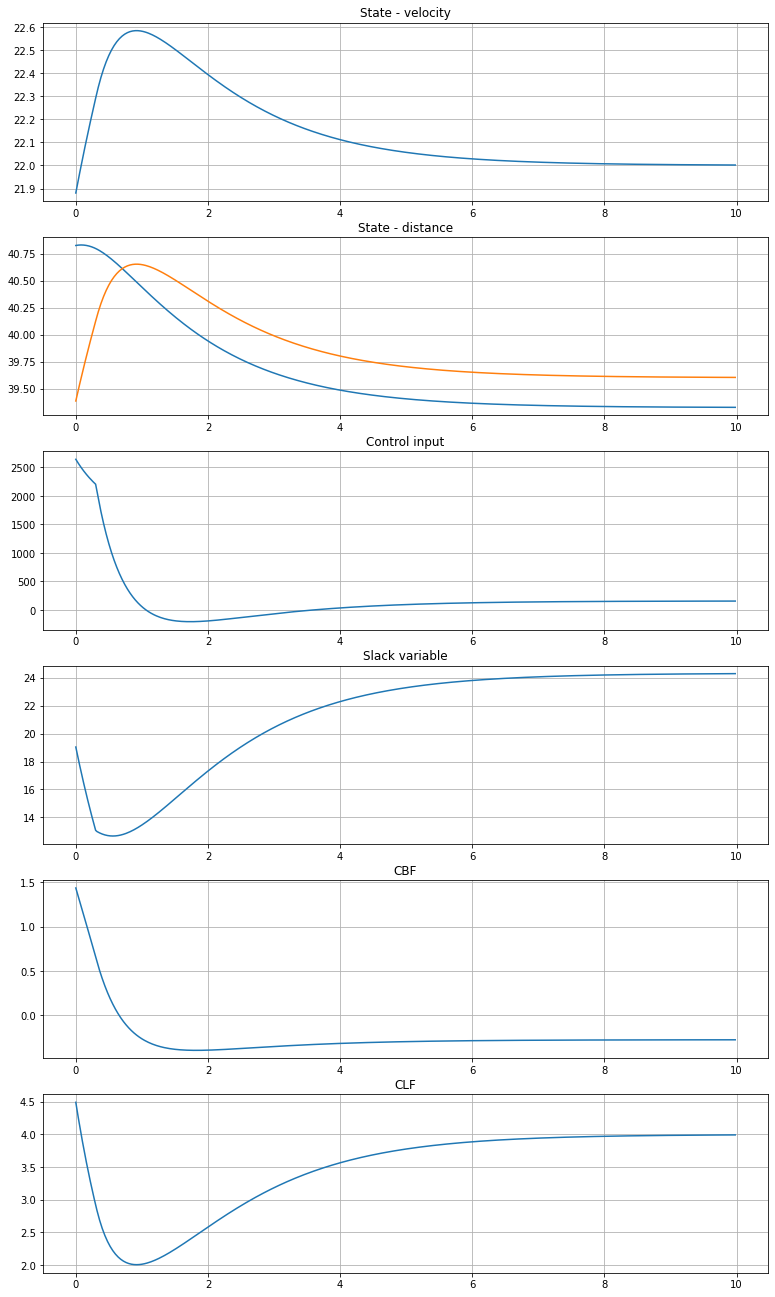

In [115]:
f,ax = plt.subplots(6,1,figsize = (13,23))
t_lns = np.arange(0, 10, dt)
exp = 0


ax[0].plot(t_lns, np.array(x_lst)[exp,:,1])
ax[0].grid(True)
ax[0].set_title('State - velocity')

ax[1].plot(t_lns, np.array(x_lst)[exp,:,2])
ax[1].grid(True)
ax[1].set_title('State - distance')

ax[1].plot(t_lns, Th*np.array(x_lst)[exp,:,1])#  + 0.5*(np.array(x_lst)[exp,:,1] - v_ego)/c_d/g)

ax[2].plot(t_lns, np.array(u_lst)[exp,:])
ax[2].grid(True)
ax[2].set_title('Control input')

ax[3].plot(t_lns, np.array(slack_lst)[exp,:])
ax[3].grid(True)
ax[3].set_title('Slack variable')

ax[4].plot(t_lns, np.array(B_lst)[exp,:])
ax[4].grid(True)
ax[4].set_title('CBF')

ax[5].plot(t_lns, np.array(V_lst)[exp,:])
ax[5].grid(True)
ax[5].set_title('CLF')


(500,)

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

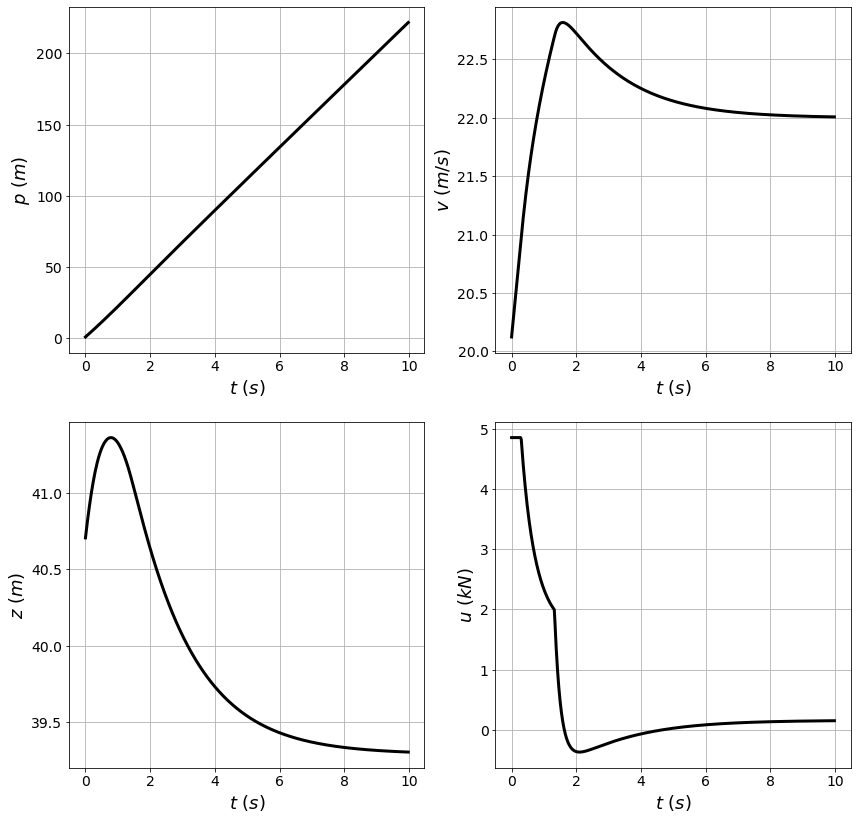

In [100]:
f,ax = plt.subplots(2,2,figsize = (14,14))
t_lns = np.arange(0, 10, dt)
exp = 9

ax[0,0].plot(t_lns, np.array(x_lst)[exp,:,0], 'k', linewidth = 3)
ax[0,0].grid(True)
ax[0,0].set_ylabel('$p$ $(m)$', fontsize = 18)
ax[0,0].set_xlabel('$t$ $(s)$', fontsize = 18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#ax[0,0].set_title('State - position')

ax[0,1].plot(t_lns, np.array(x_lst)[exp,:,1], 'k', linewidth = 3)
ax[0,1].grid(True)
ax[0,1].set_ylabel('$v$ $(m/s)$', fontsize = 18)
ax[0,1].set_xlabel('$t$ $(s)$', fontsize = 18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#ax[0,1].set_title('State - velocity')

ax[1,0].plot(t_lns, np.array(x_lst)[exp,:,2],'k', linewidth = 3)
ax[1,0].grid(True)
ax[1,0].set_ylabel('$z$ $(m)$', fontsize = 18)
ax[1,0].set_xlabel('$t$ $(s)$', fontsize = 18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#ax[1,0].set_title('State - distance')

ax[1,1].plot(t_lns, np.array(u_lst)[exp,:]/1000, 'k', linewidth = 3)
ax[1,1].grid(True)
ax[1,1].set_ylabel('$u$ $(kN)$', fontsize = 18)
ax[1,1].set_xlabel('$t$ $(s)$', fontsize = 18)
#ax[1,1].tick_params(fontsize=14)
plt.yticks(fontsize=14)
plt.setp(ax[0,0].get_xticklabels(), fontsize=14)
plt.setp(ax[0,0].get_yticklabels(), fontsize=14)

plt.setp(ax[0,1].get_xticklabels(), fontsize=14)
plt.setp(ax[0,1].get_yticklabels(), fontsize=14)

plt.setp(ax[1,0].get_xticklabels(), fontsize=14) 
plt.setp(ax[1,0].get_yticklabels(), fontsize=14)



plt.setp(ax[1,1].get_xticklabels(), fontsize=14)
plt.setp(ax[1,1].get_yticklabels(), fontsize=14)


#ax[1,1].set_title('State - distance')

(array([-50.,   0.,  50., 100., 150., 200., 250.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

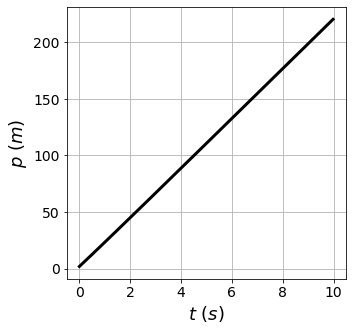

In [122]:
f,ax = plt.subplots(1,1,figsize = (5,5))
t_lns = np.arange(0, 10, dt)
exp = 9

ax.plot(t_lns, np.array(x_lst)[exp,:,0], 'k', linewidth = 3)
ax.grid(True)
ax.set_ylabel('$p$ $(m)$', fontsize = 18)
ax.set_xlabel('$t$ $(s)$', fontsize = 18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#ax[0,0].set_title('State - position')

(array([18.5, 19. , 19.5, 20. , 20.5, 21. , 21.5, 22. , 22.5, 23. ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

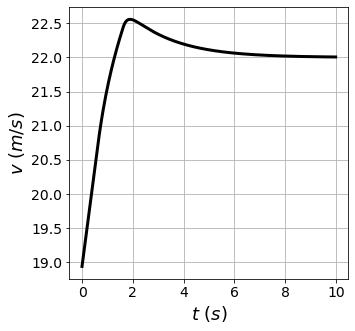

In [121]:
f,ax = plt.subplots(1,1,figsize = (5,5))
t_lns = np.arange(0, 10, dt)
exp = 8

ax.plot(t_lns, np.array(x_lst)[exp,:,1], 'k', linewidth = 3)
ax.grid(True)
ax.set_ylabel('$v$ $(m/s)$', fontsize = 18)
ax.set_xlabel('$t$ $(s)$', fontsize = 18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#ax[0,0].set_title('State - position')

(array([39.  , 39.25, 39.5 , 39.75, 40.  , 40.25, 40.5 , 40.75, 41.  ,
        41.25]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

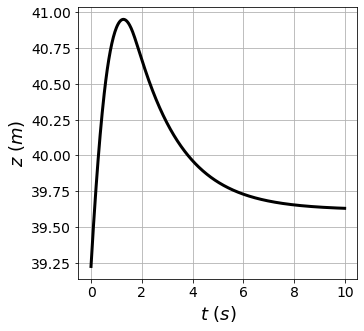

In [123]:
f,ax = plt.subplots(1,1,figsize = (5,5))
t_lns = np.arange(0, 10, dt)
exp = 8

ax.plot(t_lns, np.array(x_lst)[exp,:,2], 'k', linewidth = 3)
ax.grid(True)
ax.set_ylabel('$z$ $(m)$', fontsize = 18)
ax.set_xlabel('$t$ $(s)$', fontsize = 18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

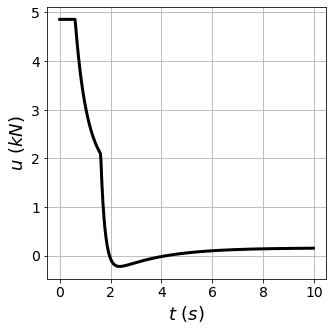

In [120]:
f,ax = plt.subplots(1,1,figsize = (5,5))
t_lns = np.arange(0, 10, dt)
exp = 8

ax.plot(t_lns, np.array(u_lst)[exp,:]/1000, 'k', linewidth = 3)
ax.grid(True)
ax.set_ylabel('$u$ $(kN)$', fontsize = 18)
ax.set_xlabel('$t$ $(s)$', fontsize = 18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

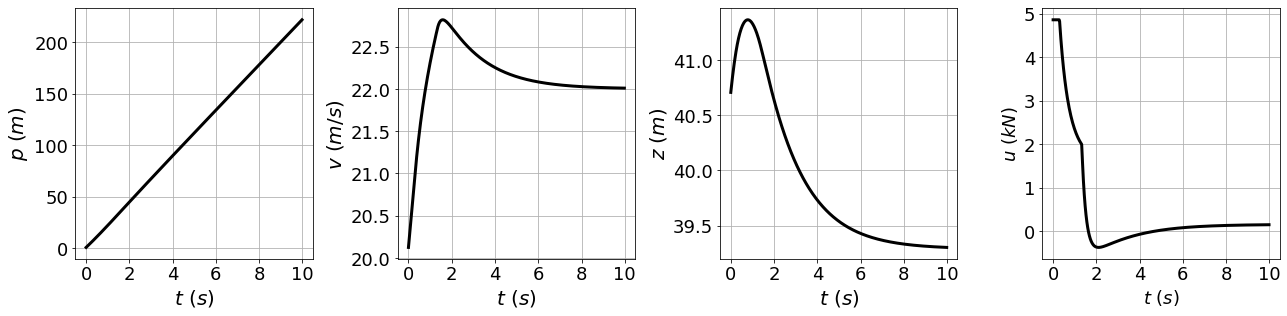

In [99]:
f,ax = plt.subplots(1,4,figsize = (18,4.5))
t_lns = np.arange(0, 10, dt)
exp = 0

ax[0].plot(t_lns, np.array(x_lst)[exp,:,0], 'k', linewidth = 3)
ax[0].grid(True)
ax[0].set_ylabel('$p$ $(m)$', fontsize = 20)
ax[0].set_xlabel('$t$ $(s)$', fontsize = 20)

ax[1].plot(t_lns, np.array(x_lst)[exp,:,1], 'k', linewidth = 3)
ax[1].grid(True)
ax[1].set_ylabel('$v$ $(m/s)$', fontsize = 20)
ax[1].set_xlabel('$t$ $(s)$', fontsize = 20)


ax[2].plot(t_lns, np.array(x_lst)[exp,:,2],'k', linewidth = 3)
ax[2].grid(True)
ax[2].set_ylabel('$z$ $(m)$', fontsize = 20)
ax[2].set_xlabel('$t$ $(s)$', fontsize = 20)

ax[3].plot(t_lns, np.array(u_lst)[exp,:]/1000, 'k', linewidth = 3)
ax[3].grid(True)
ax[3].set_ylabel('$u$ $(kN)$', fontsize = 18)
ax[3].set_xlabel('$t$ $(s)$', fontsize = 18)



plt.setp(ax[0].get_xticklabels(), fontsize=18)
plt.setp(ax[0].get_yticklabels(), fontsize=18)

plt.setp(ax[1].get_xticklabels(), fontsize=18)
plt.setp(ax[1].get_yticklabels(), fontsize=18)

plt.setp(ax[2].get_xticklabels(), fontsize=18) 
plt.setp(ax[2].get_yticklabels(), fontsize=18)

plt.setp(ax[3].get_xticklabels(), fontsize=18)
plt.setp(ax[3].get_yticklabels(), fontsize=18)

f.tight_layout() 
#ax[1,1].set_title('State - distance')

### Barrier function

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

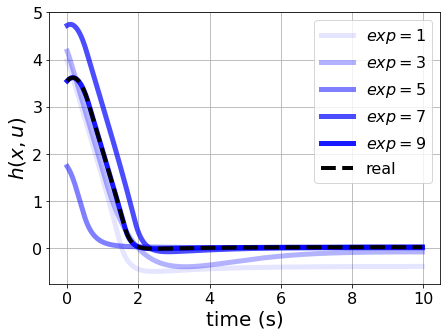

In [124]:
f,ax = plt.subplots(1,1,figsize = (7,5))
t_lns = np.arange(0, 10, dt)
exp = 8

start = 0



for exp in range(10):
    if exp % 2 == 0:
        h = np.array(x_lst)[exp,start:,2] - Th*np.array(x_lst)[exp,start:,1]  - 0.5*(np.array(x_lst)[exp,start:,1] - v_ego)/c_d/g
        h = np.array(B_lst)[exp,start:]
        ax.plot(t_lns[start:], h , 'blue', alpha = 0.1 * (exp + 1), linewidth = 5)
        #print(exp)
        
h_perf = np.array(B_lst)[exp,start:]
ax.plot(t_lns[start:], h,'black',linewidth = 4, linestyle = '--')

ax.grid(True)
#ax.set_title('Barrier function evolution in multiple experiences', fontsize= 18)
ax.legend(['$exp=1$','$exp=3$','$exp=5$','$exp=7$','$exp=9$','real'],fontsize= 16) 
ax.set_xlabel('time (s)', fontsize= 20)
ax.set_ylabel('$h(x, u)$', fontsize= 20)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)



### Lyapunov function

Text(0, 0.5, '$V(x, u)$')

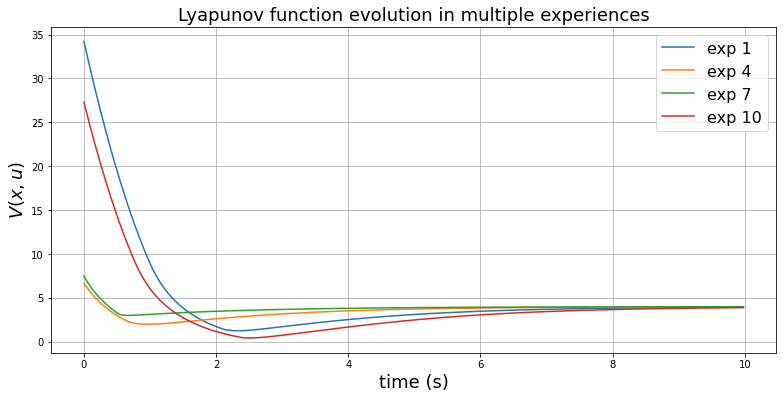

In [27]:
f,ax = plt.subplots(1,1,figsize = (13,6))
t_lns = np.arange(0, 10, dt)
exp = 8

start = 0

for exp in range(10):
    if exp % 3 == 0:
        V = np.array(V_lst)[exp,start:]
        ax.plot(t_lns[start:], V )
        #print(exp)
        
ax.grid(True)
ax.set_title('Lyapunov function evolution in multiple experiences', fontsize= 18)
ax.legend(['exp 1','exp 4','exp 7','exp 10'],fontsize= 16) 
ax.set_xlabel('time (s)', fontsize= 18)
ax.set_ylabel('$V(x, u)$', fontsize= 18)

### Comparison with perfect knowledge

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

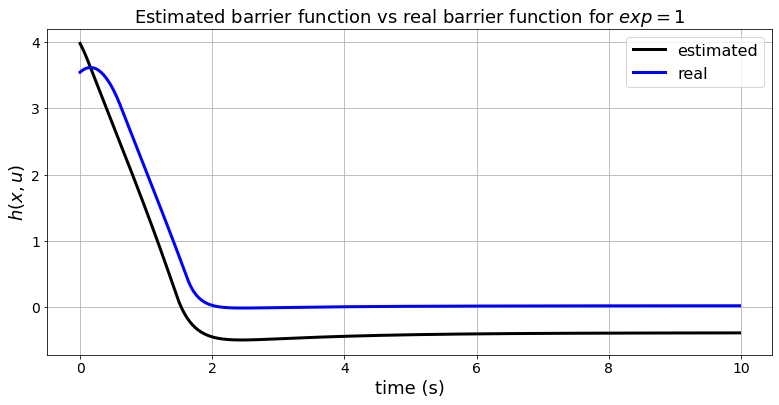

In [125]:
f,ax = plt.subplots(1,1,figsize = (13,6))
t_lns = np.arange(0, 10, dt)

start = 0
exp = 0

h_perf = np.array(B_perf_lst)[exp,start:]
ax.plot(t_lns[start:], h_perf, 'black',linewidth = 3 )

h_perf = np.array(B_lst)[exp,start:]
ax.plot(t_lns[start:], h,'blue',linewidth = 3)
#print(exp)
        
ax.grid(True)
ax.set_title('Estimated barrier function vs real barrier function for $exp = 1$', fontsize= 18)
ax.legend(['estimated','real'],fontsize= 16) 
ax.set_xlabel('time (s)', fontsize= 18)
ax.set_ylabel('$h(x, u)$', fontsize= 18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

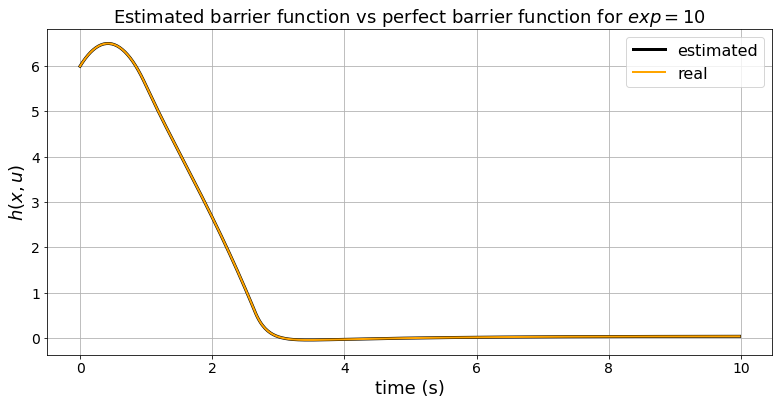

In [37]:
f,ax = plt.subplots(1,1,figsize = (13,6))
t_lns = np.arange(0, 10, dt)

start = 0
exp = 9

h_perf = np.array(B_perf_lst)[exp,start:]
ax.plot(t_lns[start:], h_perf, 'black',linewidth = 3 )

h_perf = np.array(B_lst)[exp,start:]
ax.plot(t_lns[start:], h,'orange',linewidth = 2)
#print(exp)
        
ax.grid(True)
ax.set_title('Estimated barrier function vs perfect barrier function for $exp = 10$', fontsize= 18)
ax.legend(['estimated','real'],fontsize= 16) 
ax.set_xlabel('time (s)', fontsize= 18)
ax.set_ylabel('$h(x, u)$', fontsize= 18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

### Estimator evolution

(array([-2.5, -2. , -1.5, -1. , -0.5,  0. ,  0.5]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

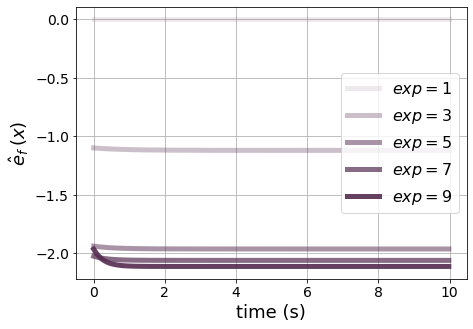

In [126]:
f,ax = plt.subplots(1,1,figsize = (7,5))
t_lns = np.arange(0, 10, dt)
exp = 8

start = 0

for exp in range(10):
    if exp % 2 == 0:
        V = np.array(a_h_lst)[exp,start:]
        ax.plot(t_lns[start:], V , color = (0.329, 0.168, 0.313), alpha = 0.1 * (exp + 1), linewidth = 5)
        #print(exp)
        
ax.grid(True)
#ax.set_title('Evolution of estimator $e_f$', fontsize= 18)
ax.legend(['$exp=1$','$exp=3$','$exp=5$','$exp=7$','$exp=9$','real'],fontsize= 16) 
ax.set_xlabel('time (s)', fontsize= 18)
ax.set_ylabel('$\hat{e}_f\:(x)$', fontsize= 18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

(array([-0.003 , -0.0025, -0.002 , -0.0015, -0.001 , -0.0005,  0.    ,
         0.0005,  0.001 ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

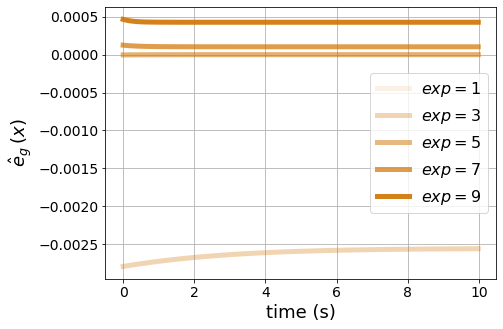

In [127]:
f,ax = plt.subplots(1,1,figsize = (7,5))
t_lns = np.arange(0, 10, dt)
exp = 8

start = 0

for exp in range(10):
    if exp % 2 == 0:
        V = np.array(b_h_lst)[exp,start:]
        ax.plot(t_lns[start:], V, color = (0.819, 0.450, 0), alpha = 0.1 * (exp + 1), linewidth = 5 )
        #print(exp) 
        
ax.grid(True)
#ax.set_title('Evolution of estimator $e_g$', fontsize= 18)
ax.legend(['$exp=1$','$exp=3$','$exp=5$','$exp=7$','$exp=9$','real'],fontsize= 16) 
ax.set_xlabel('time (s)', fontsize= 18)
ax.set_ylabel('$\hat{e}_g\:(x)$', fontsize= 18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

(array([35., 36., 37., 38., 39., 40., 41., 42., 43., 44.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

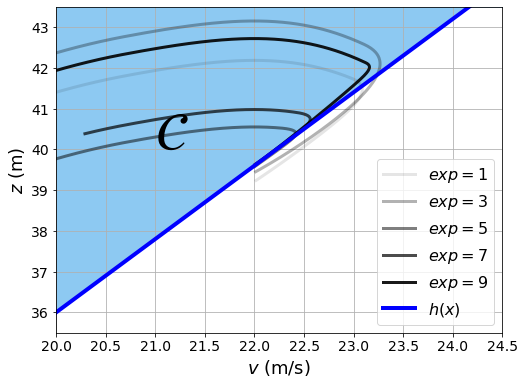

In [18]:
f,ax = plt.subplots(1,1,figsize = (8,6))
t_lns = np.arange(0, 10, dt)

start = 0
exp = 9

#h_perf = np.array(B_perf_lst)[exp,start:]

for exp in range(10):
    if exp % 2 == 0:
        z = np.array(x_lst)[exp,start:,2]# np.array(B_lst)[exp,start:]
        v = np.array(x_lst)[exp,start:,1]
        ax.plot(v, z, 'black', alpha = 0.1 * (exp + 1), linewidth = 3)
        

        
        
ax.grid(True)
#ax.set_title('Safe distance performance vs velocity. $z \geq T_h v$', fontsize= 18)
#ax.legend(['estimated','real'],fontsize= 16) 
ax.set_ylabel('$z$ (m)', fontsize= 18)
ax.set_xlabel('$v$ (m/s)', fontsize= 18)

v_min = 20
v_max = 24.5
z_min = 35.5
z_max = 43.5

v_span = np.linspace(v_min, v_max, 50)
ax.plot(v_span, v_span*Th, 'blue',linewidth = 4 )


ax.legend(['$exp=1$','$exp=3$','$exp=5$','$exp=7$','$exp=9$','$h(x)$'],fontsize= 16) 
plt.gca().fill_between(v_span, v_span*Th, z_max, v_span > 0, color = (0.552, 0.788, 0.949))
ax.set_ylim(z_min, z_max)
ax.set_xlim(v_min, v_max)

ax.text(21,40,'$\mathcal{C}$', fontsize=54)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

In [ ]:
f,ax = plt.subplots(1,1,figsize = (13,6))
t_lns = np.arange(0, 10, dt)

start = 0

for exp in range(10):
    if exp % 3 == 0:
        h_ = np.array(B_perf_lst)[exp,start:]
        ax.plot(t_lns[start:], h )
        #print(exp)
        
ax.grid(True)
ax.set_title('Barrier function evolution in multiple experiences', fontsize= 18)
ax.legend(['exp 1','exp 4','exp 7','exp 10'],fontsize= 16) 
ax.set_xlabel('time (s)', fontsize= 18)
ax.set_ylabel('$V(x, u)$', fontsize= 18)

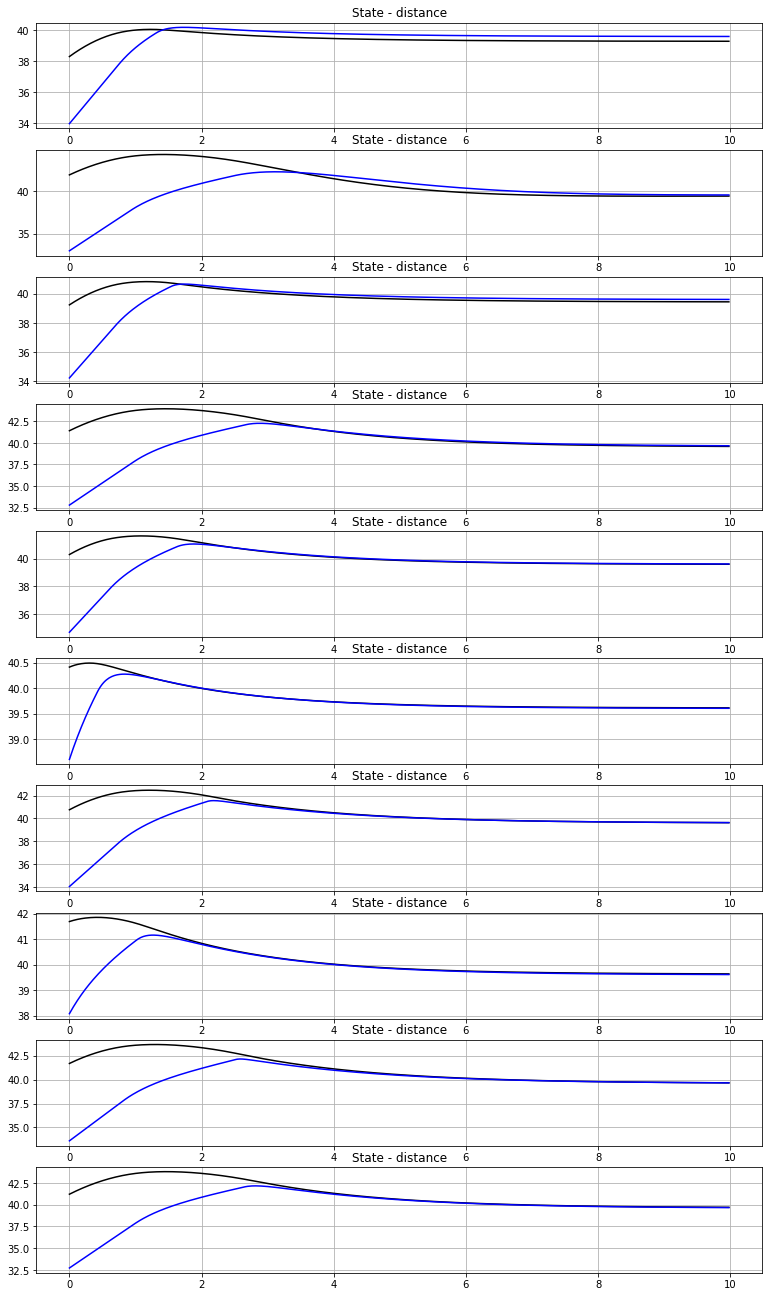

In [73]:
f,ax = plt.subplots(10,1,figsize = (13,23))
t_lns = np.arange(0, 10, dt)

for exp in range(10):
    ax[exp].plot(t_lns, np.array(x_lst)[exp,:,2],'black')
    ax[exp].grid(True)
    ax[exp].set_title('State - distance')

    ax[exp].plot(t_lns, Th*np.array(x_lst)[exp,:,1], 'blue')

### First time